## CNN For Image Classification - PyTorch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [15]:
# Device configuration (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Hyperparameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [17]:

# CIFAR-10 dataset (images and labels)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


/Users/kindsonmunonye/.local/share/virtualenvs/Tutorials-sFON5jcL/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kindsonmunonye/.local/share/virtualenvs/Tutorials-sFON5jcL/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


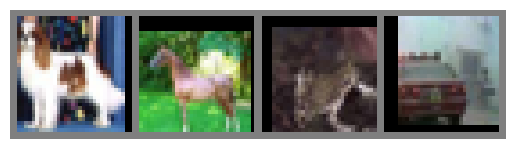

dog horse frog automobile


In [18]:
import matplotlib.pyplot as plt
import numpy as np
# Function to unnormalize and show image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize if you used transforms.Normalize((0.5,), (0.5,))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))  # visualize first 4 images in a batch

# Print labels
print(' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(4)))

In [ ]:
# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.flatten = nn.Flatten(1, -1) # Flattens from the 1st dimension to the last. Batch size is 0th dimension 
        self.fc_layer = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10) # CIFAR-10 has 10 classes
        )


    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten. Can also use self.flatten(x)
        x = self.fc_layer(x)
        # Apply softmax to the output
        # x = torch.softmax(x, dim=1)
        return x

SyntaxError: invalid syntax (3977755584.py, line 27)

In [ ]:
#Define the model
model = SimpleCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

In [ ]:

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # Print the running loss and accuracy
        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {running_loss/100:.4f}, Accuracy: {100*correct/total:.2f}%')
        #     running_loss = 0.0
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total_step:.4f}, Accuracy: {100*correct/total:.2f}%')

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Test Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')

# Save the model checkpoint (optional)
torch.save(model.state_dict(), 'cnn_cifar10.pth')

In [ ]:
# Visualize the network architecture
from torchsummary import summary
summary(model, (3, 32, 32)) # summary does not expect the batch size, so we can use any number

In [ ]:
# Visualize the model in a tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/cifar10_experiment_1')

# Add the model graph
dummy_input = torch.randn(64, 3, 32, 32).to(device)
writer.add_graph(model, dummy_input)
writer.close()

In [ ]:
# Launch TensorBoard
!tensorboard --logdir=runs